#### Treatment Comparison
Compare barcoded subpopulations of idling and untreated (control) SKMEL5 cells by their cell-cell distance in PCA space

In [1]:
# load files and packages
from fcc_utils import *
from fcc_DRs import *

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# reload functions when editing file
import sys
del sys.modules['fcc_DRs']
from fcc_DRs import *

Read in data files and associate barcodes with RNA counts

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 32.9 s, sys: 5.95 s, total: 38.9 s
Wall time: 39.8 s


Check out shape of counts matrices and barcode abundance

Untreated control: (2886, 25370)
Treated idling cells: (3524, 25370)


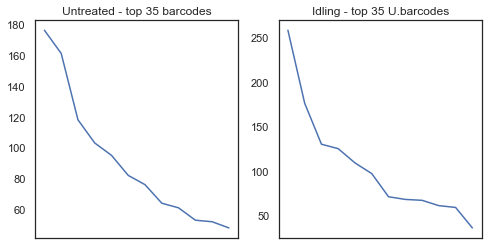

In [23]:
print('Untreated control: ' + str(U.data.shape))
print('Treated idling cells: ' + str(I.data.shape))

top12 = [x for x in range(1,13)]
plt.figure(figsize=(8,4))

plt.subplot(121)
U.barcode_counts(IDs=U.top_barcodes(top12)).plot()
plt.title('Untreated - top 35 barcodes')

plt.subplot(122)
I.barcode_counts(IDs=U.top_barcodes(top12)).plot()
plt.title('Idling - top 35 U.barcodes')

plt.show()

Using top 35 barcodes in __Untreated__ set, look at abundance in __Idling__ set

In [24]:
min(U.barcode_counts(IDs=U.top_barcodes(top12)))

48

In [25]:
min(I.barcode_counts(IDs=U.top_barcodes(top12)))

36

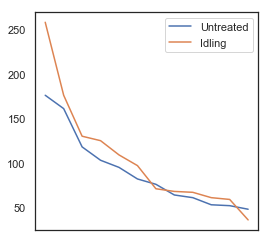

In [26]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top12)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top12)).plot(label='Idling', legend=True)
plt.show()

Perform PCA on each dataset and plot selected barcodes

In [27]:
# first get list of codes to use throughout the rest of analysis
selected_codes = U.top_barcodes(top12)

In [28]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(), barcodes=U.barcodes, n_components=100)

CPU times: user 14.1 s, sys: 3.28 s, total: 17.4 s
Wall time: 12.9 s


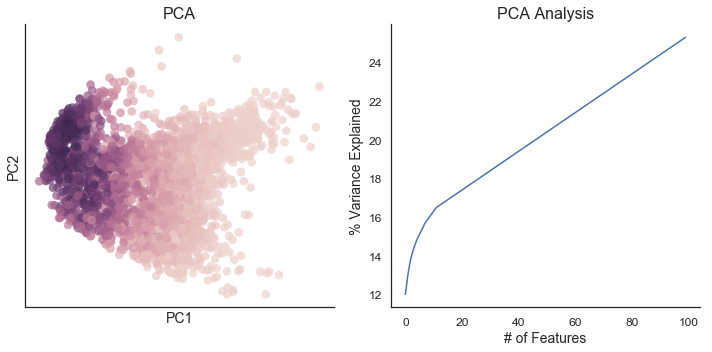

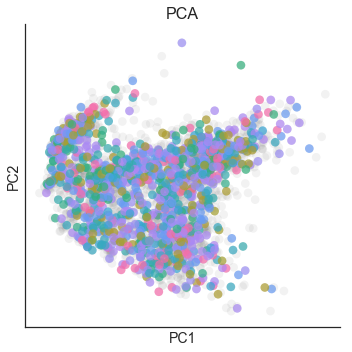

In [29]:
U_PCA.plot()
U_PCA.plot_barcodes(ranks=selected_codes)

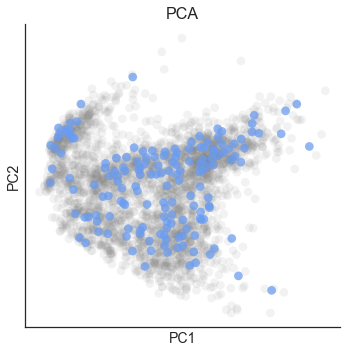

In [30]:
U_PCA.plot_barcodes(ranks=[selected_codes[1]])

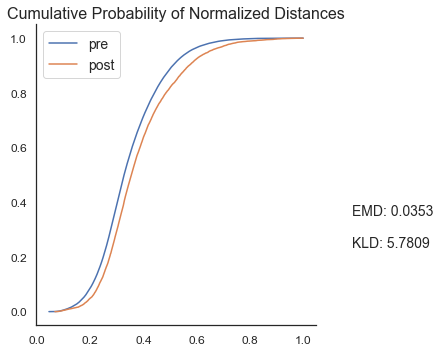

(0.03532715496540425, 5.780854629027939)

In [32]:
compare_distance_dist(pre=U_PCA.distance_matrix(ranks='all'), post=U_PCA.distance_matrix(ranks=[selected_codes[1]]))

In [33]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(), barcodes=I.barcodes, n_components=100)

CPU times: user 16.7 s, sys: 4.3 s, total: 21 s
Wall time: 15.7 s


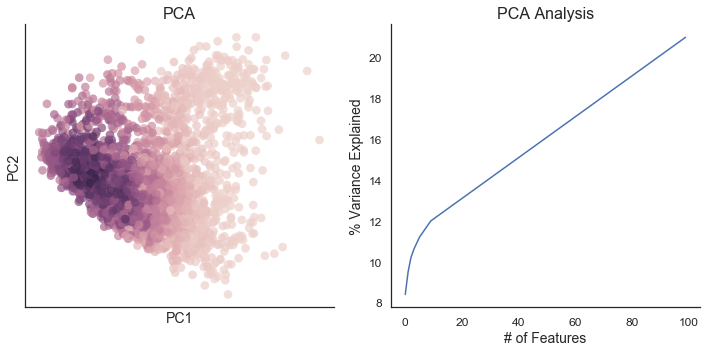

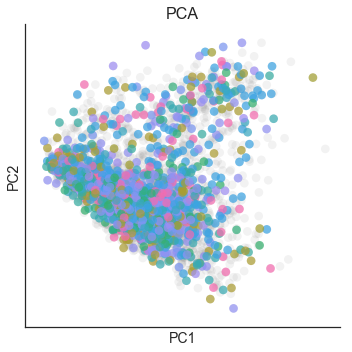

In [34]:
I_PCA.plot()
I_PCA.plot_barcodes(selected_codes)

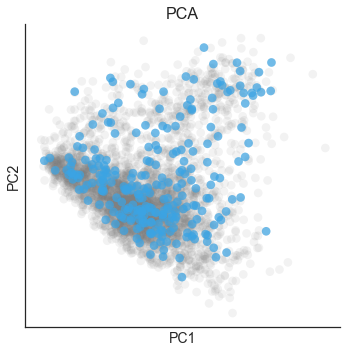

In [35]:
I_PCA.plot_barcodes(ranks=[selected_codes[1]])

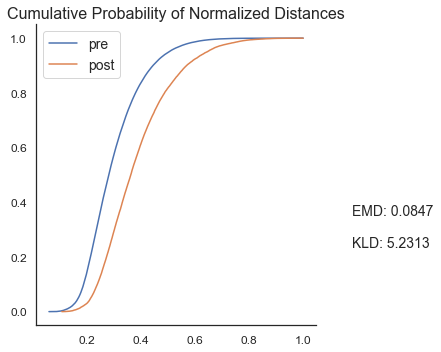

(0.08467203350131357, 5.231255672773582)

In [36]:
compare_distance_dist(pre=I_PCA.distance_matrix(ranks='all'), post=I_PCA.distance_matrix(ranks=[selected_codes[1]]))

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

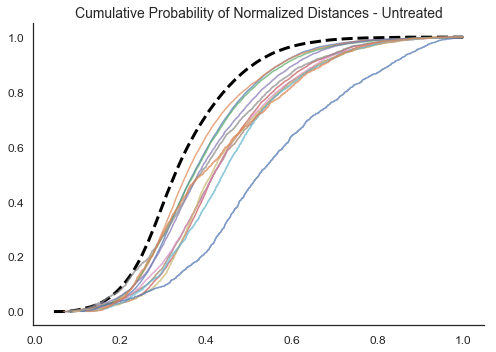

CPU times: user 20.4 s, sys: 1.28 s, total: 21.6 s
Wall time: 21.5 s


In [39]:
%%time
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_PCA.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

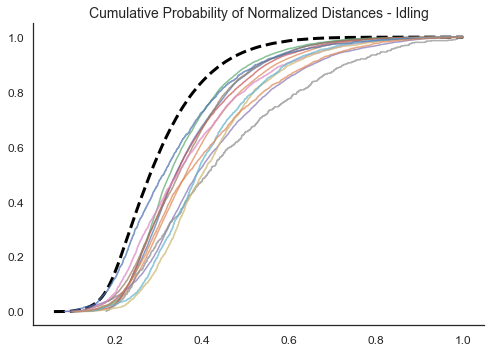

CPU times: user 31.1 s, sys: 1.41 s, total: 32.5 s
Wall time: 32.6 s


In [40]:
%%time
pre = I_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram(pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum(pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = I_PCA.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_out = pd.DataFrame(I_out)

---
Now, we want to generate statistical confidence in the "noise" or tolerance for EMD using random subsampling for calculation of EMD from the null population.

Need to correct for number of cells in each barcode, and bias in EMD compared to whole population. The acceptance criteria line should be fit to number of cells and have some growing uncertainty around it.

In [42]:
U.barcode_counts(selected_codes)

CTGAGTCAGAGTGACACACT    176
CTGAGAGTGAGTCTGTCAGT    161
CTGAGTCACTCACTGAGTGT    118
CTGAGTGTGAGAGTGTGTGT    103
CTGACAGTGTCACACAGTGA     95
CTGAGAGACTCTGTGACTGA     82
CTGAGACTCAGACAGACACT     76
CTGACTGTCAGACAGAGTGA     64
CTGAGTCAGTCACACTCTGT     61
CTGACTGTCTGTCAGTGTGT     53
CTGACAGTGTGTCAGTCTCT     52
CTGAGAGTCACTGAGTGTGT     48
Name: Barcode, dtype: int64

In [46]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_PCA.results[np.random.choice(U_PCA.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

CPU times: user 3min 31s, sys: 6.2 s, total: 3min 37s
Wall time: 3min 38s


In [49]:
U_noisefit = np.poly1d(np.polyfit(U_baseline_curve.melt(id_vars='n_cells')['n_cells'],U_baseline_curve.melt(id_vars='n_cells')['value'], 1))


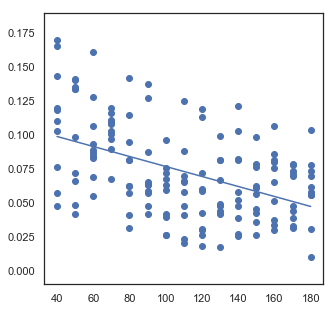

In [53]:
plt.figure(figsize=(5,5))
plt.scatter(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], y=U_baseline_curve.melt(id_vars='n_cells')['value'])
plt.plot(np.arange(40, 181, 10), U_noisefit(np.arange(40, 181, 10)))
plt.show()

---
Do the same as above for __Idling__ dataset

In [43]:
I.barcode_counts(selected_codes)

CTGAGAGTGAGTCTGTCAGT    258
CTGAGTCAGAGTGACACACT    176
CTGAGTGTGAGAGTGTGTGT    130
CTGAGTCACTCACTGAGTGT    125
CTGACAGTGTCACACAGTGA    109
CTGAGAGACTCTGTGACTGA     97
CTGAGAGTCACTGAGTGTGT     71
CTGAGTCAGTCACACTCTGT     68
CTGAGACTCAGACAGACACT     67
CTGACAGTGTGTCAGTCTCT     61
CTGACTGTCTGTCAGTGTGT     59
CTGACTGTCAGACAGAGTGA     36
Name: Barcode, dtype: int64

In [55]:
%%time 
# range of top 12 barcodes in idling dataset is 30 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = I_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

I_baseline_curve = []
for rep in np.arange(1,11):
    I_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(30, 261, 10):
        I_rand = U_PCA.results[np.random.choice(U_PCA.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(I_rand, I_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        I_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        I_baseline_curve = pd.DataFrame({'n_cells':np.arange(30, 261, 10), 'EMD1':I_EMD})
        
    else:
        I_baseline_curve['EMD{}'.format(rep)] = I_EMD

TypeError: list indices must be integers or slices, not str

In [ ]:
I_noisefit = np.poly1d(np.polyfit(I_baseline_curve.melt(id_vars='n_cells')['n_cells'],I_baseline_curve.melt(id_vars='n_cells')['value'], 3))


In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], y=U_baseline_curve.melt(id_vars='n_cells')['value'])
plt.plot(np.arange(30, 261, 10), I_noisefit(np.arange(30, 261, 10)))
plt.show()

In [ ]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=U_noisefit(U.barcode_counts(selected_codes)), xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=I_noisefit(I.barcode_counts(selected_codes)), xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()